# RAFT

In [1]:
! pip install -r ../requirements.txt

## Synthetic data generation phase

### Select the documents

In [2]:
import pandas as pd
ds_name = "ucb-DEMO"
doc_path = "../sample_data/UC_Berkeley_short.pdf"
ds_path = f"dataset/{ds_name}"
print("Creating dataset: " + ds_name)

Creating dataset: ucb-DEMO


### Overview of PDF

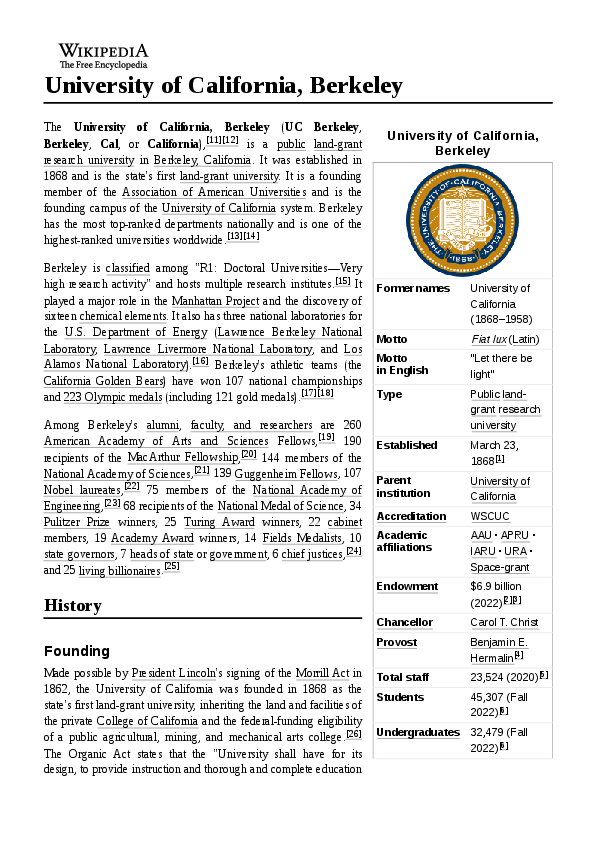

In [3]:
def get_pdf_image(doc_path):
    from wand.image import Image as WImage
    from pathlib import Path
    img = None
    if Path(doc_path).exists() and Path(doc_path).is_file():
        img = WImage(filename=doc_path)

        # make background of img white
        img.format = 'png'
        img.background_color = 'white'
        img.alpha_channel = 'remove'
    return img
get_pdf_image(doc_path)

### Clean up the DEMO folder

In [4]:
# Clean up demo folder only if it's a DEMO dataset
if ds_path.endswith("DEMO"):
    import shutil
    print(f"Cleaning demo folder {ds_path}")
    shutil.rmtree(ds_path, ignore_errors=True)
    print(f"Cleaning demo checkpoints folder {ds_path}")
    shutil.rmtree(ds_path + "-checkpoints", ignore_errors=True)

Cleaning demo folder dataset/ucb-DEMO
Cleaning demo checkpoints folder dataset/ucb-DEMO


### Generate Q/A/CoT fine-tuning dataset using RAFT from the domain specific documents

In [5]:
! python3 ../raft.py \
    --datapath "$doc_path" \
    --output $ds_path \
    --distractors 3 \
    --doctype pdf \
    --chunk_size 512 \
    --questions 1 \
    --workers 2 \
    --system-prompt-key llama \
    --completion_model Meta-Llama-3-70B-Instruct \
    --embedding_model text-embedding-ada-002

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
2024-05-30 02:13:51  INFO [  0%] raft Using checkpoint chunks /workspaces/gorilla/raft/azure-ai-studio-ft/dataset/ucb-DEMO-checkpoints/chunks
2024-05-30 02:13:51  INFO [  0%] raft Retrieving chunks from ../sample_data/UC_Berkeley_short.pdf of type pdf using the text-embedding-ada-002 model.
Chunking: 100%|██████████████████████| 1/1 [00:01<00:00,  1.18s/file, chunks=30]
2024-05-30 02:13:52  INFO [  0%] raft Using system prompt key llama
2024-05-30 02:13:52  INFO [  0%] raft Using 2 worker threads
Generating: 100%|█| 30/30 [02:50<00:00,  5.68s/chunk, qa=30, last tok/s=2.08e+4,
2024-05-30 02:16:43  INFO [  0%] raft Consumed 24959 prompt tokens, 5501 completion tokens, 30460 total tokens
Creating json from Arrow format: 100%|████████████| 1/1 [00:00<00:00, 52.82ba/s]
2024-05-30 02:16:43  INFO [  0%] raft Generated 30 question/answer

## Prepare training, validation and evaluation splits

In [6]:
raft_arrow_file = f"{ds_path}/data-00000-of-00001.arrow"
dataset_path = f"{ds_path}-files/{ds_name}-full.jsonl"
dataset_path_hf = f"{ds_path}-files/{ds_name}-hf.full.jsonl"

dataset_path_hf_train = f"{ds_path}-files/{ds_name}-hf.train.jsonl"
dataset_path_hf_valid = f"{ds_path}-files/{ds_name}-hf.valid.jsonl"
dataset_path_hf_eval = f"{ds_path}-files/{ds_name}-hf.eval.jsonl"

dataset_path_ft_train = f"{ds_path}-files/{ds_name}-ft.train.jsonl"
dataset_path_ft_valid = f"{ds_path}-files/{ds_name}-ft.valid.jsonl"
dataset_path_ft_eval = f"{ds_path}-files/{ds_name}-ft.eval.jsonl"

print(f"Reading arrow file {raft_arrow_file}")

Reading arrow file dataset/ucb-DEMO/data-00000-of-00001.arrow


### Export dataset to JSONL

In [7]:
! python ../format.py \
    --input $raft_arrow_file \
    --output $dataset_path_hf \
    --output-format hf

Generating train split: 30 examples [00:00, 4030.27 examples/s]
2024-05-30 02:16:47  INFO [    ] raft Dataset has 30 rows
2024-05-30 02:16:47  INFO [    ] raft Converting arrow file dataset/ucb-DEMO/data-00000-of-00001.arrow to jsonl hf file dataset/ucb-DEMO-files/ucb-DEMO-hf.full.jsonl
Creating json from Arrow format: 100%|████████████| 1/1 [00:00<00:00, 92.58ba/s]


In [8]:
hf_full_df = pd.read_json(dataset_path_hf, lines=True)
hf_full_df.head(5)

,id,type,question,context,oracle_context,cot_answer,instruction
0,154dff72-1204-4dca-a28f-e2d28a4fd080,general,Where was Jack Weinberg arrested?,{'sentences': [['Nimitz established the first ...,"In 1964, the Free\nSpeech Movement organized s...","To answer the question, we need to identify th...",<DOCUMENT>Nimitz established the first Naval R...
1,0091e519-00c6-4405-9415-9672f2453a0e,general,What was Berkeley's originally reported alumni...,"{'sentences': [['Hermalin[4] Total staff 23,52...",Berkeley had originally reported that its two-...,"To answer the question, we need to identify Be...","<DOCUMENT>Hermalin[4]\nTotal staff 23,524 (202..."
2,6d36952a-71a7-4509-abfe-7f155410f71c,general,Who is Physics professor J.?,"{'sentences': [['News since at least 2014.', '...",Physics professor J.,"To answer the question, we need to identify wh...",<DOCUMENT>News since at\nleast 2014.</DOCUMENT...
3,718e8623-89ad-4932-8324-4935675b2b43,general,Who was the university leader from 2013-2017?,{'sentences': [['Birgeneau 2013–2017 Nicholas ...,Birgeneau\n2013–2017 Nicholas B.,"To answer the question, we need to identify th...",<DOCUMENT>Birgeneau\n2013–2017 Nicholas B.</DO...
4,49b45a33-76a4-4057-9cd6-fbf9eb57890c,general,What percentage of the Best Colleges ranking i...,{'sentences': [['The alumni giving rate accoun...,The alumni giving rate accounts for five perce...,"To answer the question, we need to identify th...",<DOCUMENT>The alumni giving rate accounts for ...


# Let's look at a sample

In [9]:
from IPython.display import display, Markdown
from random import randint
sample_idx = randint(0, len(hf_full_df) - 1)
sample = hf_full_df.iloc[sample_idx]
instruction_md = sample.instruction.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
oracle_context_md = sample.oracle_context.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
sample_answer_md = sample.cot_answer.replace("<ANSWER>", "`<ANSWER>`").replace("##begin_quote##", "`##begin_quote##`").replace("##end_quote##", "`##end_quote##`")
display(Markdown(f"## Oracle Context\n{oracle_context_md}\n\n## Question\n{sample.question}\n\n## CoT Answer\n{sample_answer_md}\n\n## Instruction\n{instruction_md}"))

## Oracle Context
Dirks
2017–present: Carol T. Christ
With the exception of gove rnment contracts, public suppor t is apportioned to Berkeley and the other
campuses of the University of California system through t he UC Office of the President and accounts for 12
percent of Berkeley's total revenues.[90] Berkeley has long benefited from private philanthropy and more
recently, alumni and their founda tions have given to the university for operations and capital
expenditures.[91] Berkeley has benefited from benefactors beyond its alumni ranks, notable among which
are Mark Zuckerberg and Priscilla Chan; Vitalik Buterin, Patrick Collison, John Collison, the Ron Conway
family, Crankstart, Elad Gil and Jennifer Huang Gil, Daniel Gross, Dustin Moskovitz and Cari Tuna, and
Hemant and Jessica Taneja, along with Jane Street principals Matt Berger, Craig Falls, Rob Granieri, James
McClave, and Adam Winkel; BP; the Bill and Melinda Gates Founda tion, billionaire Sir Li Ka-Shing,
Israeli-Russian billionaire Yuri Milner, Thomas and Stacey Siebel, Sanford and Joan Weill, and professorGovernance
Funding

## Question
What percentage of Berkeley's total revenues comes from public support?

## CoT Answer
To answer the question, we need to identify the percentage of Berkeley's total revenues that comes from public support.

The context provided gives us the necessary information to determine this.

First, we look for the part of the context that directly mentions public support and its contribution to Berkeley's total revenues.

We find it in the sentence: `##begin_quote##`With the exception of government contracts, public support is apportioned to Berkeley and the other campuses of the University of California system through the UC Office of the President and accounts for 12 percent of Berkeley's total revenues.`##end_quote##`.

From this sentence, we understand that public support accounts for a specific percentage of Berkeley's total revenues.

The percentage is explicitly mentioned in the same sentence as 12 percent.

Therefore, based on the context provided, we can conclude that 12 percent of Berkeley's total revenues comes from public support.

`<ANSWER>`: 12%

## Instruction
`<DOCUMENT>`Native Americans contended with the school over repatriation of remains from
the Phoebe A. Hearst Museum of Anthropology.[65] Student activists have urged the
university to cut financial ties with Tyson Foods and PepsiCo.[66][67][68] Faculty member
Ignacio Chapela prominently criticized the university's financial ties to Novartis.[69] PETA
has challenged the university's use of animals for research and argued that it may violate the
Animal Welfare Act.[70][71]
Cal's Memorial Stadium reopened in September 2012 after renovations. The university
incurred a controversial $445 million of debt for the stadium and a new $153 million student
athletic center, which it financed with the sale of special stadium endowment seats.[72] The
roughly $18 million interest-only annual payments on the debt consumes 20 percent of Cal's
athletics' budget; principal repayment begins in 2032 and is scheduled to conclude in
2113.[73]
On May 1, 2014, Berkeley was named one of fifty-five higher education institutions under
investigation by the U.S.`</DOCUMENT>`
`<DOCUMENT>`Dirks
2017–present: Carol T. Christ
With the exception of gove rnment contracts, public suppor t is apportioned to Berkeley and the other
campuses of the University of California system through t he UC Office of the President and accounts for 12
percent of Berkeley's total revenues.[90] Berkeley has long benefited from private philanthropy and more
recently, alumni and their founda tions have given to the university for operations and capital
expenditures.[91] Berkeley has benefited from benefactors beyond its alumni ranks, notable among which
are Mark Zuckerberg and Priscilla Chan; Vitalik Buterin, Patrick Collison, John Collison, the Ron Conway
family, Crankstart, Elad Gil and Jennifer Huang Gil, Daniel Gross, Dustin Moskovitz and Cari Tuna, and
Hemant and Jessica Taneja, along with Jane Street principals Matt Berger, Craig Falls, Rob Granieri, James
McClave, and Adam Winkel; BP; the Bill and Melinda Gates Founda tion, billionaire Sir Li Ka-Shing,
Israeli-Russian billionaire Yuri Milner, Thomas and Stacey Siebel, Sanford and Joan Weill, and professorGovernance
Funding`</DOCUMENT>`
`<DOCUMENT>`The institute is now widely regarded as a leading center for collaborative mathematical research,
drawing thousands of visiting researchers from around t he world each year.[53][54][55]
In the current century, Berkeley has become less politically active, although more liberal.[56][57] Democrats
outnumber Republicans on the faculty by a ratio of nine to one, which is a ratio similar to that of American
academia generally.[58] The school has become more focused on STEM disciplines and
fundraising.[59][60][61] In 2007, the Energy Biosciences Institute was established with funding from BP and
Stanley Hall, a research facility and headqua rters for the California Institute for Quantitative Biosciences,
opened. Suppor ted by a grant from alumnus James Simons, the Simons Institute for the Theory of
Computing was established in 2012.`</DOCUMENT>`
`<DOCUMENT>`Department of Education's Office of Civil Rights "for possible
violations of federal law over the handling of sexual violence and harassment complaints" by
the White House Task Force to Protect Students from Sexual Assault.[74] Investigations
continued into 2016, with hundreds of pages of records released in April 2016, showing a
pattern of documented sexual harassment and firings of non-tenured staff.[75]
On July 25, 2019, Berkeley was removed from the U.S.`</DOCUMENT>`
What percentage of Berkeley's total revenues comes from public support?

### Do the splitting

In [10]:
# split dataset into 80%/10%/10%
import numpy as np
samples_count = len(hf_full_df)
hf_train_df, hf_valid_df, hf_eval_df = np.split(hf_full_df, [int(.8*samples_count), int(.9*samples_count)])
hf_train_df.to_json(dataset_path_hf_train, orient="records", lines=True)
hf_valid_df.to_json(dataset_path_hf_valid, orient="records", lines=True)
hf_eval_df.to_json(dataset_path_hf_eval, orient="records", lines=True)

/workspaces/gorilla/raft/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Export training and validation datasets into JSONL format

In [11]:
! python ../format.py \
    --input $dataset_path_hf_train \
    --input-type jsonl \
    --output $dataset_path_ft_train \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 24 examples [00:00, 4195.00 examples/s]
2024-05-30 02:16:49  INFO [    ] raft Dataset has 24 rows
2024-05-30 02:16:49  INFO [    ] raft Converting jsonl file dataset/ucb-DEMO-files/ucb-DEMO-hf.train.jsonl to jsonl completion file dataset/ucb-DEMO-files/ucb-DEMO-ft.train.jsonl
Filter out empty examples: 100%|███████| 24/24 [00:00<00:00, 4114.75 examples/s]
Rename fields and add <STOP> token: 100%|█| 24/24 [00:00<00:00, 7393.02 examples
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 414.70ba/s]


In [12]:
! python ../format.py \
    --input $dataset_path_hf_valid \
    --input-type jsonl \
    --output $dataset_path_ft_valid \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 3 examples [00:00, 653.35 examples/s]
2024-05-30 02:16:50  INFO [    ] raft Dataset has 3 rows
2024-05-30 02:16:50  INFO [    ] raft Converting jsonl file dataset/ucb-DEMO-files/ucb-DEMO-hf.valid.jsonl to jsonl completion file dataset/ucb-DEMO-files/ucb-DEMO-ft.valid.jsonl
Filter out empty examples: 100%|██████████| 3/3 [00:00<00:00, 687.48 examples/s]
Rename fields and add <STOP> token: 100%|█| 3/3 [00:00<00:00, 1072.99 examples/s
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 368.73ba/s]


In [13]:
dataset_path_ft_valid_df = pd.read_json(dataset_path_ft_valid, lines=True)
dataset_path_ft_valid_df.head(2)

,text,ground_truth
0,<DOCUMENT>It is a founding\nmember of the Asso...,"To answer the question, we need to identify th..."
1,<DOCUMENT>Bowker\n1980–1990 Ira Michael Heyman...,"To answer the question, we need to identify wh..."


### Export evaluation dataset into JSONL format

In [14]:
! python ../format.py \
    --input $dataset_path_hf_eval \
    --input-type jsonl \
    --output $dataset_path_ft_eval \
    --output-format eval

Generating train split: 3 examples [00:00, 657.41 examples/s]
2024-05-30 02:16:53  INFO [    ] raft Dataset has 3 rows
2024-05-30 02:16:53  INFO [    ] raft Converting jsonl file dataset/ucb-DEMO-files/ucb-DEMO-hf.eval.jsonl to jsonl eval file dataset/ucb-DEMO-files/ucb-DEMO-ft.eval.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 403.14ba/s]


In [15]:
dataset_path_ft_eval_df = pd.read_json(dataset_path_ft_eval, lines=True)
dataset_path_ft_eval_df.head(2)

,question,gold_final_answer,context
0,What is considered the unofficial flagship of ...,Berkeley,<DOCUMENT>It is a founding\nmember of the Asso...
1,What is the ratio of Democrats to Republicans ...,9:1,<DOCUMENT>Berdahl\n2004–2013 Robert J.</DOCUME...
